In [89]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import DataFrame
from pandas import concat
from datetime import datetime
import matplotlib.pyplot as pyplot

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

## Glimpse Data

Read data

In [28]:
btc = pd.read_csv('/data/bitsampUSD.zip')
# Converting the Timestamp column from string to datetime
btc['Timestamp'] = [datetime.fromtimestamp(x) for x in btc['Timestamp']]
btc = btc.set_index('Timestamp')

Select an eventful time period in Bitcoin history

In [29]:
# Select the years 2017 on
btc = btc.loc['2017':]

#### Time resampling

In [30]:
#btc = btc.resample("24H").mean() #daily resampling
btc = btc.resample('1H').mean() # hourly resampling
#btc = btc # no resampling
print(btc.shape)
btc.head()

(35041, 7)


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2017-01-01 00:00:00,966.305455,966.390303,966.146667,966.271818,3.105600,3000.829873,966.271116
2017-01-01 01:00:00,964.358125,964.389063,964.179062,964.207813,4.657049,4491.147445,964.290325
2017-01-01 02:00:00,964.255333,964.285000,964.092333,964.121667,3.142247,3030.057872,964.179967
2017-01-01 03:00:00,963.974359,964.022308,963.870000,963.925897,1.990248,1916.324339,963.933474
2017-01-01 04:00:00,962.803810,962.882857,962.794286,962.855714,2.229058,2145.459786,962.847834


In [31]:
def fill_missing(df):
    ### function to impute missing values using interpolation ###
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Weighted_Price'] = df['Weighted_Price'].interpolate()
    df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
    df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()
    print(df.head())
    print(df.isnull().sum())
    
fill_missing(btc)

                           Open        High         Low       Close  \
Timestamp                                                             
2017-01-01 00:00:00  966.305455  966.390303  966.146667  966.271818   
2017-01-01 01:00:00  964.358125  964.389063  964.179062  964.207813   
2017-01-01 02:00:00  964.255333  964.285000  964.092333  964.121667   
2017-01-01 03:00:00  963.974359  964.022308  963.870000  963.925897   
2017-01-01 04:00:00  962.803810  962.882857  962.794286  962.855714   

                     Volume_(BTC)  Volume_(Currency)  Weighted_Price  
Timestamp                                                             
2017-01-01 00:00:00      3.105600        3000.829873      966.271116  
2017-01-01 01:00:00      4.657049        4491.147445      964.290325  
2017-01-01 02:00:00      3.142247        3030.057872      964.179967  
2017-01-01 03:00:00      1.990248        1916.324339      963.933474  
2017-01-01 04:00:00      2.229058        2145.459786      962.847834  
Open 

#### Plot time series

array([<AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>], dtype=object)

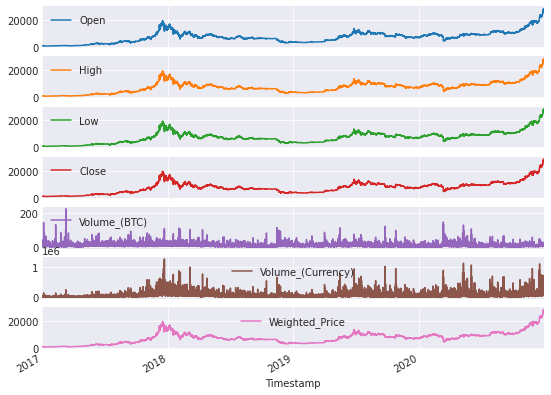

In [32]:
#axes = opsd_daily[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

btc.plot(figsize=(9,7), subplots=True)
#plt.plot()

<AxesSubplot:xlabel='Timestamp'>

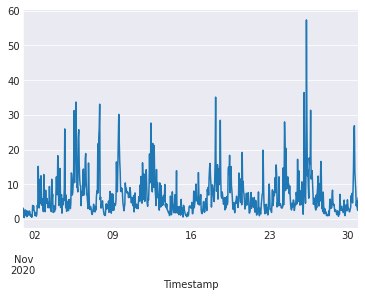

In [36]:
# plot close price during 2020
btc.loc['2020-11', 'Volume_(BTC)'].plot()

#### Keras Long Short-Term Memory (LSTM) Model

In [37]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [95]:
# load dataset
values = btc.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [96]:
ncols = reframed.shape[1]

In [97]:
print(reframed)

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.007299   0.007285   0.007306   0.007290   0.333048   0.002208   
2       0.007230   0.007214   0.007236   0.007216   0.496318   0.003364   
3       0.007226   0.007210   0.007233   0.007213   0.337871   0.002231   
4       0.007216   0.007201   0.007225   0.007206   0.186045   0.001367   
5       0.007175   0.007160   0.007187   0.007168   0.218836   0.001545   
...          ...        ...        ...        ...        ...        ...   
35036   0.995065   0.994997   0.993658   0.994030   0.943436   0.450594   
35037   0.996833   0.996387   0.995870   0.995640   0.860731   0.282488   
35038   0.998127   0.997657   0.997147   0.996995   0.710502   0.176605   
35039   0.997399   0.996775   0.996528   0.996042   0.427112   0.088182   
35040   0.997052   0.996505   0.996450   0.995768   0.238870   0.052937   

       var7(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  \
1       0.007296  0

In [98]:

reframed.drop(reframed.columns[[ncols-7,ncols-6,ncols-5,ncols-3,ncols-2,ncols-1]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.007299   0.007285   0.007306   0.007290   0.333048   0.002208   
2   0.007230   0.007214   0.007236   0.007216   0.496318   0.003364   
3   0.007226   0.007210   0.007233   0.007213   0.337871   0.002231   
4   0.007216   0.007201   0.007225   0.007206   0.186045   0.001367   
5   0.007175   0.007160   0.007187   0.007168   0.218836   0.001545   

   var7(t-1)   var4(t)  
1   0.007296  0.007216  
2   0.007226  0.007213  
3   0.007222  0.007206  
4   0.007213  0.007168  
5   0.007174  0.007185  


In [99]:
# split into train and test sets
values = reframed.values
n_test_hours = 90 * 24
n_train_hours = values.shape[0] - n_test_hours
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(32880, 1, 7) (32880,) (2160, 1, 7) (2160,)


In [104]:

# design network
#model = Sequential()
#model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')
# fit network
#history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2])))
regressor.add(Dropout(0.2))

#regressor.add(LSTM(units = 50, return_sequences = True))
#regressor.add(Dropout(0.2))

#regressor.add(LSTM(units = 50, return_sequences = True))
#regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = regressor.fit(train_X, train_y, epochs = 300, batch_size = 32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/300
1028/1028 - 6s - loss: 9.5800e-04 - val_loss: 0.0609
Epoch 2/300
1028/1028 - 5s - loss: 0.0019 - val_loss: 0.0486
Epoch 3/300
1028/1028 - 6s - loss: 0.0014 - val_loss: 0.0367
Epoch 4/300
1028/1028 - 4s - loss: 7.8776e-04 - val_loss: 0.0290
Epoch 5/300
1028/1028 - 4s - loss: 4.4302e-04 - val_loss: 0.0302
Epoch 6/300
1028/1028 - 4s - loss: 3.9087e-04 - val_loss: 0.0350
Epoch 7/300
1028/1028 - 7s - loss: 4.2457e-04 - val_loss: 0.0398
Epoch 8/300
1028/1028 - 9s - loss: 4.5024e-04 - val_loss: 0.0409
Epoch 9/300
1028/1028 - 4s - loss: 4.4548e-04 - val_loss: 0.0401
Epoch 10/300
1028/1028 - 5s - loss: 4.5015e-04 - val_loss: 0.0403
Epoch 11/300
1028/1028 - 5s - loss: 4.3295e-04 - val_loss: 0.0403
Epoch 12/300
1028/1028 - 5s - loss: 4.4763e-04 - val_loss: 0.0419
Epoch 13/300
1028/1028 - 7s - loss: 4.5918e-04 - val_loss: 0.0409
Epoch 14/300
1028/1028 - 4s - loss: 4.2990e-04 - val_loss: 0.0404
Epoch 15/300
1028/1028 - 4s - loss: 4.4817e-04 - val_loss: 0.0415
Epoch 16/300
1028/1028 - 4s

Epoch 125/300
1028/1028 - 4s - loss: 2.1229e-04 - val_loss: 0.0135
Epoch 126/300
1028/1028 - 4s - loss: 2.1380e-04 - val_loss: 0.0127
Epoch 127/300
1028/1028 - 4s - loss: 2.1636e-04 - val_loss: 0.0120
Epoch 128/300
1028/1028 - 4s - loss: 1.9930e-04 - val_loss: 0.0118
Epoch 129/300
1028/1028 - 4s - loss: 2.1399e-04 - val_loss: 0.0128
Epoch 130/300
1028/1028 - 4s - loss: 2.0467e-04 - val_loss: 0.0119
Epoch 131/300
1028/1028 - 4s - loss: 1.9646e-04 - val_loss: 0.0129
Epoch 132/300
1028/1028 - 4s - loss: 2.1040e-04 - val_loss: 0.0126
Epoch 133/300
1028/1028 - 4s - loss: 1.9727e-04 - val_loss: 0.0121
Epoch 134/300
1028/1028 - 6s - loss: 2.0385e-04 - val_loss: 0.0122
Epoch 135/300
1028/1028 - 4s - loss: 2.0622e-04 - val_loss: 0.0131
Epoch 136/300
1028/1028 - 4s - loss: 1.9986e-04 - val_loss: 0.0136
Epoch 137/300
1028/1028 - 5s - loss: 2.1356e-04 - val_loss: 0.0143
Epoch 138/300
1028/1028 - 7s - loss: 2.0567e-04 - val_loss: 0.0117
Epoch 139/300
1028/1028 - 5s - loss: 2.0353e-04 - val_loss: 0.

Epoch 248/300
1028/1028 - 5s - loss: 1.6411e-04 - val_loss: 0.0080
Epoch 249/300
1028/1028 - 7s - loss: 1.8191e-04 - val_loss: 0.0091
Epoch 250/300
1028/1028 - 5s - loss: 1.7711e-04 - val_loss: 0.0078
Epoch 251/300
1028/1028 - 6s - loss: 1.7081e-04 - val_loss: 0.0073
Epoch 252/300
1028/1028 - 5s - loss: 1.7314e-04 - val_loss: 0.0071
Epoch 253/300
1028/1028 - 6s - loss: 1.7728e-04 - val_loss: 0.0083
Epoch 254/300
1028/1028 - 6s - loss: 1.7427e-04 - val_loss: 0.0074
Epoch 255/300
1028/1028 - 5s - loss: 1.7098e-04 - val_loss: 0.0081
Epoch 256/300
1028/1028 - 5s - loss: 1.7854e-04 - val_loss: 0.0081
Epoch 257/300
1028/1028 - 5s - loss: 1.8240e-04 - val_loss: 0.0081
Epoch 258/300
1028/1028 - 5s - loss: 1.7856e-04 - val_loss: 0.0078
Epoch 259/300
1028/1028 - 5s - loss: 1.7003e-04 - val_loss: 0.0080
Epoch 260/300
1028/1028 - 5s - loss: 1.8097e-04 - val_loss: 0.0081
Epoch 261/300
1028/1028 - 6s - loss: 1.7426e-04 - val_loss: 0.0066
Epoch 262/300
1028/1028 - 6s - loss: 1.7445e-04 - val_loss: 0.

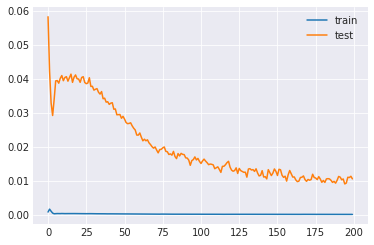

In [103]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()